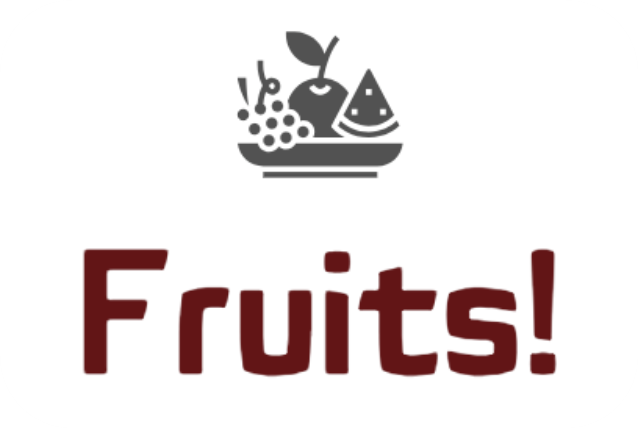

In [13]:
from PIL import Image
from io import BytesIO, StringIO
import numpy as np
import boto3
import pandas as pd

In [14]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from keras.layers import Flatten
from keras import Model

2022-11-17 14:25:22.022197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 14:25:22.346572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 14:25:22.346620: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 14:25:22.381321: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 14:25:23.381687: W tensorflow/stream_executor/pla

In [15]:
from pyspark import SparkContext, SparkConf

**Connexion au S3**

In [16]:
region_name='eu-west-3'
bucket_name='fruits-app-data'
s3 = boto3.resource('s3', region_name=region_name)
bucket = s3.Bucket(bucket_name)

Répupération de la liste des images du fichier de test

In [17]:
client = boto3.client('s3', region_name='eu-west-3')
paginator = client.get_paginator('list_objects')
operation_parameters = {'Bucket': 'fruits-app-data',
                        'Prefix': 'fruits-360-original-size/fruits-360-original-size/Test/'}
page_iterator = paginator.paginate(**operation_parameters)

list_files=[]
for page in page_iterator:
    for content in page['Contents']:
        list_files.append(content['Key'])

In [18]:
print(f'Il y a {len(list_files)} images dans le dossier Test')

Il y a 3110 images dans le dossier Test


**Modèle VGG-16**

In [19]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model.summary()
# Récupérer la sortie de ce réseau
x = model.output

# Ajout des couches de sorties du nouveau modèle
flatten=Flatten()(x)
fc1=Dense(512, activation='relu')(flatten)
fc2=Dense(512, activation='relu')(fc1)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=fc2)

new_model.summary()

2022-11-17 14:25:43.319107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-17 14:25:43.319162: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-17 14:25:43.319181: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-34-140.eu-west-3.compute.internal): /proc/driver/nvidia/version does not exist
2022-11-17 14:25:43.319815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Pyspark** 

Parrallélisation du chargement et prétraitement des images

In [23]:
conf = SparkConf()
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/17 14:26:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/17 14:26:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [24]:
broadcast=sc.broadcast(new_model)

INFO:tensorflow:Assets written to: ram://fdf96589-c736-4a86-b7af-bb52192939bc/assets


INFO:tensorflow:Assets written to: ram://fdf96589-c736-4a86-b7af-bb52192939bc/assets


In [25]:
broadcast.value

**Fonction de chargement et prétraitement d'une image**

In [26]:
def process_image(key):
    
    
    region_name='eu-west-3'
    bucket_name='fruits-app-data'
    s3 = boto3.resource('s3', region_name=region_name)
    bucket = s3.Bucket(bucket_name)
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    img=im.resize((224,224))
    img = tf.keras.preprocessing.image.img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
    
    feat_vect=broadcast.value.predict(img)

    
    return feat_vect

In [27]:
img_files=list_files[:1000] # échantillon d' images

In [28]:
rdd = sc.parallelize(img_files)

In [29]:
array_rdd = rdd.map(lambda img: process_image(img))

In [15]:
%%time
feat_vec_list = array_rdd.collect()

2022-11-17 13:06:00.813690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 13:06:00.826722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 13:06:00.830664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

CPU times: user 397 ms, sys: 103 ms, total: 500 ms
Wall time: 1min 38s


1/1 [==============================] - 0s 163ms/step


**Ecriture du resultat sur S3**

In [16]:
feat_matrix=np.concatenate(feat_vec_list, axis=0)
df=pd.DataFrame(feat_matrix)
df_csv=df.to_csv()

In [17]:
object = s3.Object(bucket_name, 'fruits-360-original-size/fruits-360-original-size/results/df_csv.csv')
object.put(Body=df_csv)

{'ResponseMetadata': {'RequestId': 'PDF47VBPCDF9T8VY',
  'HostId': '93oUxC9vTAkAh/s3pjEsE02G961HQi59tohDzqRMzJ/iUI9FPeyVSd8Xqu5ppRxVJ3tsFQdtXIQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '93oUxC9vTAkAh/s3pjEsE02G961HQi59tohDzqRMzJ/iUI9FPeyVSd8Xqu5ppRxVJ3tsFQdtXIQ=',
   'x-amz-request-id': 'PDF47VBPCDF9T8VY',
   'date': 'Thu, 17 Nov 2022 13:07:39 GMT',
   'etag': '"7da77b4b438b536702fdc3fe70ec1088"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"7da77b4b438b536702fdc3fe70ec1088"'}

**Analyse de la configuration spark**

In [18]:
sc.getConf().getAll()

[('spark.driver.port', '39825'),
 ('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'ip-172-31-34-140.eu-west-3.compute.internal'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.submitTime', '1668690352842'),
 ('spark.app.

In [19]:
sc.getConf().get('spark.master')

'local[*]'

In [20]:
print(sc._conf.get('spark.executor.instances'))

None


In [41]:
#arrêt spark
sc.stop()

**processing sur une combinaison de différents executor/cores**

In [31]:
from time import process_time

In [43]:
dic={}
for i in range(1,9):
    for j in range(1,9): 
                  
            conf = SparkConf()
            conf.set('spark.master', 'local'+'['+str(i)+']')
            conf.set("spark.executor.cores", j)
            
            sc = SparkContext(conf=conf)
            broadcast=sc.broadcast(new_model)
            rdd = sc.parallelize(img_files)
            array_rdd = rdd.map(lambda img: process_image(img))
            t1=process_time()
            feat_vec_list = array_rdd.collect()
            t2=process_time()
            dic[(i,j)]=t2-t1
            sc.stop()             

22/11/17 15:48:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://7ba67220-e13f-4d15-a59a-2a705470039f/assets


INFO:tensorflow:Assets written to: ram://7ba67220-e13f-4d15-a59a-2a705470039f/assets
2022-11-17 15:48:34.658892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 15:48:34.968430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 15:48:34.968466: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 15:48:35.011937: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

22/11/17 15:52:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://87182fc9-e4df-467d-abc4-ab3328d5dd10/assets


INFO:tensorflow:Assets written to: ram://87182fc9-e4df-467d-abc4-ab3328d5dd10/assets
2022-11-17 15:52:40.836484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 15:52:41.076904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 15:52:41.076996: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 15:52:41.107366: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

22/11/17 15:56:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://a2b53682-cd01-4ad1-8407-77006ea15fd1/assets


INFO:tensorflow:Assets written to: ram://a2b53682-cd01-4ad1-8407-77006ea15fd1/assets
2022-11-17 15:56:47.745883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 15:56:48.001471: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 15:56:48.001505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 15:56:48.035893: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

22/11/17 16:00:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://e55b6c1e-afe9-49d8-ad22-a76e039795be/assets


INFO:tensorflow:Assets written to: ram://e55b6c1e-afe9-49d8-ad22-a76e039795be/assets
2022-11-17 16:00:53.799160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:00:54.030195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 16:00:54.030293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 16:00:54.060536: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

22/11/17 16:05:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://f6139062-b5c3-4111-bee3-cf3e154a2dfd/assets


INFO:tensorflow:Assets written to: ram://f6139062-b5c3-4111-bee3-cf3e154a2dfd/assets
2022-11-17 16:05:27.849911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:05:28.129122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 16:05:28.129212: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 16:05:28.165514: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

22/11/17 16:09:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://9ce447e2-3aba-4eec-9d6e-d2f4a0e58b09/assets


INFO:tensorflow:Assets written to: ram://9ce447e2-3aba-4eec-9d6e-d2f4a0e58b09/assets
2022-11-17 16:09:48.392791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:09:48.603213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 16:09:48.603246: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 16:09:48.632771: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

22/11/17 16:13:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://eac3d785-f0cf-40e1-8e42-85cc13b95b6f/assets


INFO:tensorflow:Assets written to: ram://eac3d785-f0cf-40e1-8e42-85cc13b95b6f/assets
2022-11-17 16:13:47.308323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:13:47.529734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 16:13:47.529765: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 16:13:47.560891: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

22/11/17 16:17:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://d4332816-dced-4362-977f-7a18c5cae181/assets


INFO:tensorflow:Assets written to: ram://d4332816-dced-4362-977f-7a18c5cae181/assets
2022-11-17 16:17:38.358822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:17:38.553003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 16:17:38.553090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 16:17:38.582031: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

22/11/17 16:21:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://b13e7af6-c499-48c8-9379-3a6208279ee3/assets


INFO:tensorflow:Assets written to: ram://b13e7af6-c499-48c8-9379-3a6208279ee3/assets
2022-11-17 16:21:29.291688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:21:29.334617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:21:29.496078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:23:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://6f62cd42-d56d-45ee-a463-6d95193567b2/assets


INFO:tensorflow:Assets written to: ram://6f62cd42-d56d-45ee-a463-6d95193567b2/assets
2022-11-17 16:23:56.491499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:23:56.528825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:23:56.710004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:26:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://5dc6fbb1-6f5d-4644-b936-db28c1f3ba23/assets


INFO:tensorflow:Assets written to: ram://5dc6fbb1-6f5d-4644-b936-db28c1f3ba23/assets
2022-11-17 16:26:22.565683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:26:22.587586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:26:22.812118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:28:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://ba38b536-599e-4a8f-8a06-235921e06881/assets


INFO:tensorflow:Assets written to: ram://ba38b536-599e-4a8f-8a06-235921e06881/assets
2022-11-17 16:28:43.872132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:28:44.011567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:28:44.111095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:31:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://0eecb2a1-e2e4-4ca0-93a8-8db75811a4b6/assets


INFO:tensorflow:Assets written to: ram://0eecb2a1-e2e4-4ca0-93a8-8db75811a4b6/assets
2022-11-17 16:31:07.099188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:31:07.102368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:31:07.298062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:33:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://51baf78c-6bf5-4fe8-965a-b537789fdda3/assets


INFO:tensorflow:Assets written to: ram://51baf78c-6bf5-4fe8-965a-b537789fdda3/assets
2022-11-17 16:33:26.729187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:33:26.880957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:33:26.928020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:35:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://65ed24fe-1740-4ad6-b332-66ce35107ab3/assets


INFO:tensorflow:Assets written to: ram://65ed24fe-1740-4ad6-b332-66ce35107ab3/assets
2022-11-17 16:35:49.569995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:35:49.691789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:35:49.759661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:38:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://85e3ef21-5b07-4b6e-98f6-b86c6648f722/assets


INFO:tensorflow:Assets written to: ram://85e3ef21-5b07-4b6e-98f6-b86c6648f722/assets
2022-11-17 16:38:09.589880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:38:09.599473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:38:09.854267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:40:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://4210853f-6ec0-4220-876a-fd0745061f99/assets


INFO:tensorflow:Assets written to: ram://4210853f-6ec0-4220-876a-fd0745061f99/assets
2022-11-17 16:40:28.862533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:40:28.906847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:40:29.062545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:42:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://316a4802-bb1b-48cc-8ac4-42824564bba3/assets


INFO:tensorflow:Assets written to: ram://316a4802-bb1b-48cc-8ac4-42824564bba3/assets
2022-11-17 16:42:24.401117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:42:24.440687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:42:24.611895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:44:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://b3b29d17-06ad-43aa-9f95-1fc351b8397c/assets


INFO:tensorflow:Assets written to: ram://b3b29d17-06ad-43aa-9f95-1fc351b8397c/assets
2022-11-17 16:44:23.230048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:44:23.253743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:44:23.332250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 16:46:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://d0eea535-48b6-4c24-826f-489f1e349411/assets


INFO:tensorflow:Assets written to: ram://d0eea535-48b6-4c24-826f-489f1e349411/assets
2022-11-17 16:46:17.160116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:46:17.169595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:46:17.356335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 16:48:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://3ac6c7ae-a539-4024-ae1f-c7a92424aa35/assets


INFO:tensorflow:Assets written to: ram://3ac6c7ae-a539-4024-ae1f-c7a92424aa35/assets
2022-11-17 16:48:12.993402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:48:13.054519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:48:13.125672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 16:50:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://491efff3-f15c-44d1-a2cb-e5ed60b80592/assets


INFO:tensorflow:Assets written to: ram://491efff3-f15c-44d1-a2cb-e5ed60b80592/assets
2022-11-17 16:50:08.490631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:50:08.535799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:50:08.576604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 16:51:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://583c5c83-0f4d-4228-a290-6f1d987bb349/assets


INFO:tensorflow:Assets written to: ram://583c5c83-0f4d-4228-a290-6f1d987bb349/assets
2022-11-17 16:52:04.137482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:52:04.161689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:52:04.241136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 16:53:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://6ac270d8-5fa5-4738-a52d-6603d6b81417/assets


INFO:tensorflow:Assets written to: ram://6ac270d8-5fa5-4738-a52d-6603d6b81417/assets
2022-11-17 16:53:59.911201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:53:59.927973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:53:59.928702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 16:55:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://77db0fcb-7627-497c-906e-b12241ac9244/assets


INFO:tensorflow:Assets written to: ram://77db0fcb-7627-497c-906e-b12241ac9244/assets
2022-11-17 16:55:59.770134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:55:59.826659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:55:59.827941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 16:57:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://599f9282-c426-45d7-8c06-6d3be5e69c42/assets


INFO:tensorflow:Assets written to: ram://599f9282-c426-45d7-8c06-6d3be5e69c42/assets
2022-11-17 16:57:46.048000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:57:46.071099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:57:46.133319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 16:59:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://8492bf16-9231-4026-b93b-5f27eed9ed30/assets


INFO:tensorflow:Assets written to: ram://8492bf16-9231-4026-b93b-5f27eed9ed30/assets
2022-11-17 16:59:33.802530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:59:33.874177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:59:33.929947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:01:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://e18659a5-bb03-4cca-bad7-fbfb4f5c546b/assets


INFO:tensorflow:Assets written to: ram://e18659a5-bb03-4cca-bad7-fbfb4f5c546b/assets
2022-11-17 17:01:23.960848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:01:24.034843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:01:24.074114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:03:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://5c526674-e74e-4372-98e1-acdea1d9d38e/assets


INFO:tensorflow:Assets written to: ram://5c526674-e74e-4372-98e1-acdea1d9d38e/assets
2022-11-17 17:03:15.067617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:03:15.099696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:03:15.130333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:04:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://0803225a-b6cc-44ee-827b-1eca8bc6b565/assets


INFO:tensorflow:Assets written to: ram://0803225a-b6cc-44ee-827b-1eca8bc6b565/assets
2022-11-17 17:05:03.000921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:05:03.105517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:05:03.281513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 17:07:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://9fddd998-317a-4446-8029-91bc6df36487/assets


INFO:tensorflow:Assets written to: ram://9fddd998-317a-4446-8029-91bc6df36487/assets
2022-11-17 17:07:05.480876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:07:05.518566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:07:05.697932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 17:08:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://5e105d9a-f18b-47bf-9e55-f5663c997582/assets


INFO:tensorflow:Assets written to: ram://5e105d9a-f18b-47bf-9e55-f5663c997582/assets
2022-11-17 17:09:01.404430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:09:01.422249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:09:01.565961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:10:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://ef79daff-5d1e-44b4-83a6-746a4b04314a/assets


INFO:tensorflow:Assets written to: ram://ef79daff-5d1e-44b4-83a6-746a4b04314a/assets
2022-11-17 17:10:53.759240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:10:53.814272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:10:53.834771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:12:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://c7967a3b-95e0-4cf9-b07e-f7e87604138d/assets


INFO:tensorflow:Assets written to: ram://c7967a3b-95e0-4cf9-b07e-f7e87604138d/assets
2022-11-17 17:12:42.924618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:12:42.938052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:12:42.948313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:14:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://192599a1-ea7a-4c76-9fc1-d2fee1a7bd8a/assets


INFO:tensorflow:Assets written to: ram://192599a1-ea7a-4c76-9fc1-d2fee1a7bd8a/assets
2022-11-17 17:14:29.432637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:14:29.531612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:14:29.633485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 17:16:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://1f0dc71e-557a-4106-b319-05dd659688fa/assets


INFO:tensorflow:Assets written to: ram://1f0dc71e-557a-4106-b319-05dd659688fa/assets
2022-11-17 17:16:16.534510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:16:16.599893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:16:16.713644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:17:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://ab4b6cb5-5f7a-4b18-8036-2c502b3108cc/assets


INFO:tensorflow:Assets written to: ram://ab4b6cb5-5f7a-4b18-8036-2c502b3108cc/assets
2022-11-17 17:18:01.007319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:18:01.025461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:18:01.171030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:19:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://ee5ce86c-7150-4137-8f11-a7cb7707c767/assets


INFO:tensorflow:Assets written to: ram://ee5ce86c-7150-4137-8f11-a7cb7707c767/assets
2022-11-17 17:19:47.866344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:19:47.883672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:19:47.977763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:23:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://70de88d7-f453-4f64-9939-3682988f10d3/assets


INFO:tensorflow:Assets written to: ram://70de88d7-f453-4f64-9939-3682988f10d3/assets
2022-11-17 17:23:22.361218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:23:22.389629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:23:22.392130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:25:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://409f348c-49e2-4034-b1c2-a439057e0d2a/assets


INFO:tensorflow:Assets written to: ram://409f348c-49e2-4034-b1c2-a439057e0d2a/assets
2022-11-17 17:25:05.171125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:25:05.178363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:25:05.196272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:26:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://962c53b3-969d-4f4d-9e9f-e2674be3af5c/assets


INFO:tensorflow:Assets written to: ram://962c53b3-969d-4f4d-9e9f-e2674be3af5c/assets
2022-11-17 17:26:50.895198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:26:50.943621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:26:50.961944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:28:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://b2acc083-4812-4c02-bb32-cbe3602fba74/assets


INFO:tensorflow:Assets written to: ram://b2acc083-4812-4c02-bb32-cbe3602fba74/assets
2022-11-17 17:28:34.812367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:28:34.814870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:28:34.905353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:30:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://8ea01714-f4a2-4bdf-bcc3-4b76bd204dcf/assets


INFO:tensorflow:Assets written to: ram://8ea01714-f4a2-4bdf-bcc3-4b76bd204dcf/assets
2022-11-17 17:30:18.266364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:30:18.292012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:30:18.462304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:31:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://db81d8c4-8545-40d6-a590-1472caf4d9e2/assets


INFO:tensorflow:Assets written to: ram://db81d8c4-8545-40d6-a590-1472caf4d9e2/assets
2022-11-17 17:32:03.040041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:32:03.069057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:32:03.123249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:33:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://0c5ad0dd-c881-4f54-8801-c803fc0c6b37/assets


INFO:tensorflow:Assets written to: ram://0c5ad0dd-c881-4f54-8801-c803fc0c6b37/assets
2022-11-17 17:33:44.766310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:33:44.832742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:33:44.941202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:35:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://b5bb3bfb-4a87-469b-b631-354e9f90db07/assets


INFO:tensorflow:Assets written to: ram://b5bb3bfb-4a87-469b-b631-354e9f90db07/assets
2022-11-17 17:35:27.448620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:35:27.513533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:35:27.591488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:37:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://3830831c-453b-465c-99d2-69b992538fa8/assets


INFO:tensorflow:Assets written to: ram://3830831c-453b-465c-99d2-69b992538fa8/assets
2022-11-17 17:37:09.927075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:37:09.979503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:37:10.114893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 17:38:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://343695c8-2f02-4503-9437-52c6cde72d79/assets


INFO:tensorflow:Assets written to: ram://343695c8-2f02-4503-9437-52c6cde72d79/assets
2022-11-17 17:38:53.276646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:38:53.301645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:38:53.425887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:40:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://2512c9b8-49f1-4a6f-94a4-59c13b191948/assets


INFO:tensorflow:Assets written to: ram://2512c9b8-49f1-4a6f-94a4-59c13b191948/assets
2022-11-17 17:40:34.781430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:40:34.903976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:40:34.903976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:42:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://1cb3c5ec-c353-47a9-a56c-3b94b400229d/assets


INFO:tensorflow:Assets written to: ram://1cb3c5ec-c353-47a9-a56c-3b94b400229d/assets
2022-11-17 17:42:16.237110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:42:16.280461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:42:16.355315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:43:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://1f616ca0-81d9-4998-86fb-4b4f7589b96d/assets


INFO:tensorflow:Assets written to: ram://1f616ca0-81d9-4998-86fb-4b4f7589b96d/assets
2022-11-17 17:43:56.463820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:43:56.512489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:43:56.575397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:45:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://9935efcf-d439-4216-ba44-b28a62a82993/assets


INFO:tensorflow:Assets written to: ram://9935efcf-d439-4216-ba44-b28a62a82993/assets
2022-11-17 17:45:41.695542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:45:41.779398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:45:41.779416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:47:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://5fe902ae-5719-46b0-bdd9-e7614efe8f75/assets


INFO:tensorflow:Assets written to: ram://5fe902ae-5719-46b0-bdd9-e7614efe8f75/assets
2022-11-17 17:47:22.302714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:47:22.451539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:47:22.462440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:49:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://3e0628ea-e029-4b58-8935-06a8aeb01c07/assets


INFO:tensorflow:Assets written to: ram://3e0628ea-e029-4b58-8935-06a8aeb01c07/assets
2022-11-17 17:49:04.287104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:49:04.294033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:49:04.365040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:50:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://22677a91-2d68-41db-b3f0-e3404e3f94d1/assets


INFO:tensorflow:Assets written to: ram://22677a91-2d68-41db-b3f0-e3404e3f94d1/assets
2022-11-17 17:50:46.818456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:50:46.818815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:50:46.861427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:52:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://57c5586d-3adf-42d9-b94c-86fdef677fc6/assets


INFO:tensorflow:Assets written to: ram://57c5586d-3adf-42d9-b94c-86fdef677fc6/assets
2022-11-17 17:52:25.821537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:52:25.918257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:52:25.935060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:54:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://a93d3849-af1e-43fe-985e-17e881a43295/assets


INFO:tensorflow:Assets written to: ram://a93d3849-af1e-43fe-985e-17e881a43295/assets
2022-11-17 17:54:04.836564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:54:04.876021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:54:04.996167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:55:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://57e173d8-95e4-494c-83bb-0765c1b87570/assets


INFO:tensorflow:Assets written to: ram://57e173d8-95e4-494c-83bb-0765c1b87570/assets
2022-11-17 17:55:47.076650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:55:47.082489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:55:47.158079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:57:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://4fa25b2a-2ff7-4a2d-9f86-1c8109449777/assets


INFO:tensorflow:Assets written to: ram://4fa25b2a-2ff7-4a2d-9f86-1c8109449777/assets
2022-11-17 17:57:34.162710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:57:34.288681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:57:34.304765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 17:59:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://34e6b97e-ee4a-45c7-b0ff-d3398ce7a2aa/assets


INFO:tensorflow:Assets written to: ram://34e6b97e-ee4a-45c7-b0ff-d3398ce7a2aa/assets
2022-11-17 17:59:14.723600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:59:14.750958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 17:59:14.755184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 18:00:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://f7629118-9ef9-418a-b38b-299a7deb08d5/assets


INFO:tensorflow:Assets written to: ram://f7629118-9ef9-418a-b38b-299a7deb08d5/assets
2022-11-17 18:01:02.738182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:01:02.909217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:01:02.968031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

22/11/17 18:02:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://c4a92263-5a62-4919-8ee1-a7a7b53415b7/assets


INFO:tensorflow:Assets written to: ram://c4a92263-5a62-4919-8ee1-a7a7b53415b7/assets
2022-11-17 18:02:48.428728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:02:48.574655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:02:48.580704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 18:04:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://0ad064b0-09c2-4e93-86e7-b51ae541d171/assets


INFO:tensorflow:Assets written to: ram://0ad064b0-09c2-4e93-86e7-b51ae541d171/assets
2022-11-17 18:04:28.210424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:04:28.448297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:04:28.455088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

22/11/17 18:06:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


INFO:tensorflow:Assets written to: ram://c44c1d17-941d-4baf-b146-699d57225313/assets


INFO:tensorflow:Assets written to: ram://c44c1d17-941d-4baf-b146-699d57225313/assets
2022-11-17 18:06:10.888526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:06:11.004427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:06:11.112712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such fil

In [58]:
df=pd.DataFrame.from_dict(dic, orient='index')

In [59]:
df=df.rename(columns={ 0:'CPU time'})

Meilleure combinaison

In [60]:
df.sort_values('CPU time').head(10)

CPU time
(7, 8)  0.445396
(7, 6)  0.464660
(6, 2)  0.465255
(4, 3)  0.468283
(7, 4)  0.468711
(7, 7)  0.469994
(8, 6)  0.470150
(4, 8)  0.470159
(4, 2)  0.470293
(7, 2)  0.471859

<AxesSubplot:>

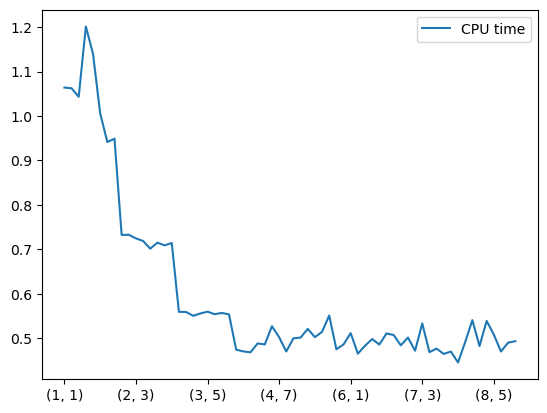

In [61]:
df.plot()